<a href="https://colab.research.google.com/github/kramerkraus/2155-CP3-mkraus/blob/main/diffusionmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [182]:
%reset -f

In [183]:
#make it so i can access files in the folder 2155-CP3-mkraus
import sys
sys.path.append('/content/2155-CP3-mkraus/')
from utils import *
from evaluate import *
import random

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [184]:
# Load dataset from CSV files
data_dir = '/content/2155-CP3-mkraus/dataset'
splits = load_dataset_splits(data_dir)

# Get feature names from the CSV file
feature_names = pd.read_csv(os.path.join(data_dir, 'train_original.csv')).columns.tolist()
print(f"\n✓ Features loaded: {len(feature_names)} features")
print(f"Feature names: {feature_names[:5]}...{feature_names[-5:]}")  # Show first and last 5

Loading dataset splits from: /content/2155-CP3-mkraus/dataset

Loading train split...
  ✓ train_original.csv: (2998, 37)
  ✓ train_imputed.csv: (2998, 37)
  ✓ train_missing_mask.csv: (2998, 37)

Loading val split...
  ✓ val_original.csv: (375, 37)
  ✓ val_imputed.csv: (375, 37)
  ✓ val_missing_mask.csv: (375, 37)

Loading test split...
  ✓ test_original.csv: (375, 37)
  ✓ test_imputed.csv: (375, 37)
  ✓ test_missing_mask.csv: (375, 37)

Loading test2 split...
  ✓ test2_imputed.csv: (417, 37)
  ✓ test2_missing_mask.csv: (417, 37)

✓ Features loaded: 37 features
Feature names: ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5']...['Feature 33', 'Feature 34', 'Feature 35', 'Feature 36', 'Feature 37']


In [185]:
# Data exploration and analysis
print("\n" + "="*70)
print("DATASET ANALYSIS")
print("="*70)

# Extract data for easier access
X_train = splits['train']['imputed']
mask_train = splits['train']['missing_mask']
X_train_original = splits['train']['original']


# for i in [24,25,18,14, 5]:
#   print(i)
#   X_traincpy = X_train.copy()

#   #pick a random number between 0 and 36
#   # k = random.randint(0,36)

#   X_traincpy[:,i] = -1
#   #append X_traincpy to the bottom of X_train
#   X_train = np.vstack((X_train, X_traincpy))

#   mask_traincpy = mask_train.copy()
#   mask_traincpy[:,i] = 1

#   #append mask_traincpy to the bottom of mask_train
#   mask_train = np.vstack((mask_train, mask_traincpy))

#   #append a copy of X_train_original to the bottom of itself
#   X_train_original = np.vstack((X_train_original, X_train_original))


X_val = splits['val']['imputed']
mask_val = splits['val']['missing_mask']
X_val_original = splits['val']['original']

X_test = splits['test']['imputed']
mask_test = splits['test']['missing_mask']
X_test_original = splits['test']['original']

# Test2 data (no original available for evaluation)
X_test2 = splits['test2']['imputed']
mask_test2 = splits['test2']['missing_mask']

print(f"\nData shapes:")
print(f"  - Training: {X_train.shape}")
print(f"  - Validation: {X_val.shape}")
print(f"  - Test: {X_test.shape}")
print(f"  - Test2: {X_test2.shape} (evaluation set - no ground truth)")


DATASET ANALYSIS

Data shapes:
  - Training: (2998, 37)
  - Validation: (375, 37)
  - Test: (375, 37)
  - Test2: (417, 37) (evaluation set - no ground truth)


In [187]:
# Data Preprocessing (Handle Missing Values)

print("\n" + "="*70)
print("DATA PREPROCESSING")
print("="*70)

# Handle missing values properly
print("Processing missing values and preparing data...")
print("Mask convention: True=missing, False=observed (in original masks)")

print(f"\n✓ Data preprocessing completed successfully")
print(f"  - Training data range: [{X_train_original[~mask_train].min():.3f}, {X_train_original[~mask_train].max():.3f}]")
print(f"  - Validation data range: [{X_val_original[~mask_val].min():.3f}, {X_val_original[~mask_val].max():.3f}]")
print(f"  - Test data range: [{X_test_original[~mask_test].min():.3f}, {X_test_original[~mask_test].max():.3f}]")

# Create data loaders
batch_size = 64
print(f"\nCreating data loaders with batch size: {batch_size}")

train_dataset = TensorDataset(torch.FloatTensor(X_train_original), torch.FloatTensor((~mask_train).astype(float)))
val_dataset = TensorDataset(torch.FloatTensor(X_val_original), torch.FloatTensor((~mask_val).astype(float)))
test_dataset = TensorDataset(torch.FloatTensor(X_test_original), torch.FloatTensor((~mask_test).astype(float)))
test2_dataset = TensorDataset(torch.FloatTensor(X_test2), torch.FloatTensor((~mask_test2).astype(float)))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test2_loader = DataLoader(test2_dataset, batch_size=batch_size, shuffle=False)

# Preview a batch
sample_batch_data, sample_batch_mask = next(iter(train_loader))
print(f"\nSample batch shape: {sample_batch_data.shape}")
print(f"Sample batch mask shape: {sample_batch_mask.shape}")
print(f"Sample batch missing percentage: {(sample_batch_mask == 0).float().mean().item()*100:.1f}%")  # 0 = missing in model tensors



DATA PREPROCESSING
Processing missing values and preparing data...
Mask convention: True=missing, False=observed (in original masks)

✓ Data preprocessing completed successfully
  - Training data range: [0.000, 1.000]
  - Validation data range: [0.000, 1.000]
  - Test data range: [0.000, 1.000]

Creating data loaders with batch size: 64

Sample batch shape: torch.Size([64, 37])
Sample batch mask shape: torch.Size([64, 37])
Sample batch missing percentage: 21.3%


In [188]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


# --------------------------------------------------
# 1. Small MLP backbone (denoiser)
# --------------------------------------------------

class MLPDenoiser(nn.Module):
    def __init__(self, input_dim=37, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1 + input_dim, hidden), # x + t + mask
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, input_dim),
        )

    def forward(self, x_t, t, mask):
        """
        x_t: noised data
        t: time step (batch, 1)
        mask: binary mask (1 = observed, 0 = missing)
        """
        t = t / 1000.0       # normalize time
        inp = torch.cat([x_t, t, mask], dim=1)
        return self.net(inp)


# --------------------------------------------------
# 2. Diffusion core (betas, schedules, noise)
# --------------------------------------------------

def make_beta_schedule(T=1000, start=1e-4, end=0.002):
    return torch.linspace(start, end, T)


class Diffusion(nn.Module):
    def __init__(self, input_dim, timesteps=1000):
        super().__init__()
        self.T = timesteps
        betas = make_beta_schedule(timesteps)
        alphas = 1.0 - betas
        alphas_cum = torch.cumprod(alphas, dim=0)

        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cum", alphas_cum)

        self.model = MLPDenoiser(input_dim=input_dim)

    # -------------------------
    # q(x_t | x_0)
    # -------------------------
    def q_sample(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        a_bar = self.alphas_cum[t].unsqueeze(1)
        return torch.sqrt(a_bar) * x0 + torch.sqrt(1 - a_bar) * noise, noise

    # -------------------------
    # Training step
    # -------------------------
    def forward(self, x0, mask):
        """
        x0 : clean data (batch, D)
        mask : 1 = observed, 0 = missing
        """
        B = x0.shape[0]
        device = x0.device

        # Random time t for each sample
        t = torch.randint(0, self.T, (B,), device=device)

        # Noise forward
        xt, noise = self.q_sample(x0, t, noise=None)

        # Condition on observed values
        xt = xt * (1 - mask) + x0 * mask

        # Predict noise
        noise_pred = self.model(xt, t.unsqueeze(1).float(), mask)

        # Loss only on missing entries
        loss = ((noise_pred - noise) ** 2 * (1 - mask)).mean()
        return loss

    # -------------------------
    # Sampling / imputation
    # -------------------------
    @torch.no_grad()
    def sample(self, x_obs, mask, guidance_scale=2.0):
      """x_obs has missing entries set to anything (will overwrite them).
      guidance_scale: w in cfg (>=1). w=1.0 -> no guidance, w>1.0 -> stronger conditioning.
      """

      x = torch.randn_like(x_obs)

      # Define the target categories for Feature 26
      feature_26_idx = 25 # Assuming 'Feature 26' is at index 25 (0-indexed)
      allowed_categories = torch.tensor([0.0, 0.5, 1.0], device=x.device, dtype=torch.float32)

      feature_25_idx = 24

      for t in reversed(range(self.T)):
          bt = self.betas[t]
          at = self.alphas[t]
          a_bar = self.alphas_cum[t]

          # ----- prepare two inputs: uncond and cond -----
          # For conditioned input, always respect observed values
          x_cond = x * (1 - mask) + x_obs * mask

          # For unconditioned input, do not inject observed values (i.e., no overwrite)
          x_uncond = x  # same x but without overwritten observed entries

          # t tensor
          t_tensor = torch.full((x.shape[0], 1), t, device=x.device).float()

          # Predict noise for uncond and cond
          noise_uncond = self.model(x_uncond, t_tensor, torch.zeros_like(mask))
          noise_cond = self.model(x_cond, t_tensor, mask)

          # Combine with guidance
          noise_pred = noise_uncond + guidance_scale * (noise_cond - noise_uncond)

          # DDPM update step (use combined noise_pred)
          coef1 = 1 / torch.sqrt(at)
          coef2 = (1 - at) / torch.sqrt(1 - a_bar)

          x = coef1 * (x - coef2 * noise_pred)

          if t > 0:
              x += torch.sqrt(bt) * torch.randn_like(x)

          # After update, ensure we keep observed values exactly (optional safety)
          x = x * (1 - mask) + x_obs * mask

          # --- Guidance for Feature 26 ---
          # Find samples where Feature 26 was originally missing
          missing_for_f26 = (mask[:, feature_26_idx] == 0)
          if missing_for_f26.any():
              # Get the current imputed values for Feature 26 for these samples
              values_to_constrain = x[missing_for_f26, feature_26_idx]

              # Calculate absolute differences to each allowed category
              diffs = torch.abs(values_to_constrain.unsqueeze(1) - allowed_categories)

              # Find the index of the closest allowed category
              closest_category_indices = torch.argmin(diffs, dim=1)

              # Snap the imputed values to the closest allowed category
              x[missing_for_f26, feature_26_idx] = allowed_categories[closest_category_indices]



           # --- Guidance for Feature 25 ---
          # Find samples where Feature 26 was originally missing
          missing_for_f25 = (mask[:, feature_25_idx] == 0)
          if missing_for_f25.any():
              # Get the current imputed values for Feature 25 for these samples
              values_to_constrain = x[missing_for_f25, feature_25_idx]

              # Calculate absolute differences to each allowed category
              diffs = torch.abs(values_to_constrain.unsqueeze(1) - allowed_categories)

              # Find the index of the closest allowed category
              closest_category_indices = torch.argmin(diffs, dim=1)

              # Snap the imputed values to the closest allowed category
              x[missing_for_f25, feature_25_idx] = allowed_categories[closest_category_indices]




      # xmin = x.min(dim=0, keepdim=True).values
      # xmax = x.max(dim=0, keepdim=True).values

      # x_scaled = (x - xmin) / (xmax - xmin + 1e-12)


      return x # x_scaled

In [189]:
model = Diffusion(input_dim=37, timesteps=18).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

In [190]:
for epoch in range(200):
    for batch, mask in train_loader:
        batch = batch.to(device)
        mask = mask.to(device)

        loss = model(batch, mask)

        opt.zero_grad()
        loss.backward()
        opt.step()

    print(f"epoch {epoch} | loss {loss.item():.4f}")

epoch 0 | loss 0.1854
epoch 1 | loss 0.2043
epoch 2 | loss 0.1788
epoch 3 | loss 0.2110
epoch 4 | loss 0.1971
epoch 5 | loss 0.1977
epoch 6 | loss 0.1849
epoch 7 | loss 0.2039
epoch 8 | loss 0.2152
epoch 9 | loss 0.2215
epoch 10 | loss 0.1945
epoch 11 | loss 0.2047
epoch 12 | loss 0.1805
epoch 13 | loss 0.2097
epoch 14 | loss 0.2305
epoch 15 | loss 0.1834
epoch 16 | loss 0.1947
epoch 17 | loss 0.1758
epoch 18 | loss 0.2063
epoch 19 | loss 0.2023
epoch 20 | loss 0.2156
epoch 21 | loss 0.2101
epoch 22 | loss 0.2302
epoch 23 | loss 0.1736
epoch 24 | loss 0.2238
epoch 25 | loss 0.2246
epoch 26 | loss 0.2159
epoch 27 | loss 0.2062
epoch 28 | loss 0.2108
epoch 29 | loss 0.1659
epoch 30 | loss 0.1534
epoch 31 | loss 0.1771
epoch 32 | loss 0.2221
epoch 33 | loss 0.1900
epoch 34 | loss 0.1992
epoch 35 | loss 0.2097
epoch 36 | loss 0.1970
epoch 37 | loss 0.2143
epoch 38 | loss 0.1956
epoch 39 | loss 0.2020
epoch 40 | loss 0.2106
epoch 41 | loss 0.1918
epoch 42 | loss 0.2071
epoch 43 | loss 0.181

In [220]:
# x_incomplete = X_test_imputed[i]      # has -1 replaced by something
# mask = (X_test_missing_mask[i] == 0)  # convert your mask to 1/0 observed/missing

# x_incomplete = torch.tensor(x_incomplete).float().to(device)
# mask = torch.tensor(mask).float().to(device)

# samples = []

# for _ in range(20):
#     x_gen = model.sample(x_incomplete.unsqueeze(0), mask.unsqueeze(0))
#     samples.append(x_gen.cpu().numpy())

# samples = np.array(samples)   # (20, 1, 37)

In [191]:
def evaluate_imputation(model, data_loader, device):
    """Evaluate imputation performance."""
    model.eval()

    all_imputations = []
    all_originals = []
    all_masks = []

    with torch.no_grad():
        for batch_data_original, batch_mask_original in data_loader:
            batch_data_original = batch_data_original.to(device)
            batch_mask_original = batch_mask_original.to(device)

            # Use the model's sampling method for imputation
            imputed_data = model.sample(batch_data_original, batch_mask_original)

            all_imputations.append(imputed_data.cpu().numpy())
            all_originals.append(batch_data_original.cpu().numpy())
            all_masks.append(batch_mask_original.cpu().numpy())

    # Concatenate all results
    imputations = np.vstack(all_imputations)
    originals = np.vstack(all_originals)
    masks = np.vstack(all_masks)

    return imputations, originals, masks

In [192]:
print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

# Evaluate on test set
print("Evaluating model on test set...")
test_imputations, test_originals, test_masks = evaluate_imputation(
    model, test_loader, device
)

print(f"✓ Test set evaluation completed")
print(f"  - Test samples: {test_imputations.shape[0]}")
print(f"  - Features: {test_imputations.shape[1]}")

test_imputations_denorm = test_imputations  # Already in original scale
test_original_denorm = X_test_original  # Already in original scale

# Calculate comprehensive metrics
print("\nCalculating comprehensive metrics...")
feature_metrics = {}

# Create masks for missing values (where we need to evaluate imputation)
missing_mask = (test_masks == 0)  # True where values were missing (0 in model tensors = missing)

for i, feature_name in enumerate(feature_names):
    if missing_mask[:, i].sum() > 0:  # Only evaluate features with missing values
        # Get imputed and ground truth values for missing positions only
        imputed_missing = test_imputations_denorm[missing_mask[:, i], i]
        ground_truth_missing = test_original_denorm[missing_mask[:, i], i]

        # Calculate metrics
        mse = mean_squared_error(ground_truth_missing, imputed_missing)
        mae = mean_absolute_error(ground_truth_missing, imputed_missing)

        # Correlation
        try:
            correlation = np.corrcoef(ground_truth_missing, imputed_missing)[0, 1]
        except:
            correlation = np.nan

        # Mean difference and Jensen-Shannon divergence
        mean_diff, js_div = calculate_jsd_and_mean_diff(
            imputed_missing, ground_truth_missing, feature_name
        )

        feature_metrics[feature_name] = {
            'n_missing': missing_mask[:, i].sum(),
            'mse': mse,
            'mae': mae,
            'correlation': correlation,
            'mean_difference': mean_diff,
            'js_divergence': js_div,
        }

print(f"✓ Metrics calculated for {len(feature_metrics)} features with missing values")

# Display metrics for last 4 features (as requested)
print(f"\n" + "="*100)
print("METRICS FOR LAST 4 FEATURES")
print("="*100)
print(f"{'Feature':<15} {'N_Miss':<8} {'MSE':<10} {'MAE':<10} {'Corr':<8} {'Mean_Diff':<10} {'JS_Div':<8}")
print("-" * 100)

last_4_features = list(feature_metrics.keys())[-4:] if len(feature_metrics) >= 4 else list(feature_metrics.keys())

for feature in last_4_features:
    metrics = feature_metrics[feature]
    print(f"{feature:<15} {metrics['n_missing']:<8} {metrics['mse']:<10.4f} {metrics['mae']:<10.4f} "
          f"{metrics['correlation']:<8.3f} {metrics['mean_difference']:<10.4f} {metrics['js_divergence']:<8.4f} ")

# Summary statistics
all_mse = [m['mse'] for m in feature_metrics.values() if not np.isnan(m['mse'])]
all_mae = [m['mae'] for m in feature_metrics.values() if not np.isnan(m['mae'])]
all_corr = [m['correlation'] for m in feature_metrics.values() if not np.isnan(m['correlation'])]
all_mean_diff = [m['mean_difference'] for m in feature_metrics.values() if not np.isnan(m['mean_difference'])]
all_js_div = [m['js_divergence'] for m in feature_metrics.values() if not np.isnan(m['js_divergence'])]

print(f"\nSummary Statistics Across All Features:")
print(f"  - Average MSE: {np.mean(all_mse):.4f} ± {np.std(all_mse):.4f}")
print(f"  - Average MAE: {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")
print(f"  - Average Correlation: {np.mean(all_corr):.3f} ± {np.std(all_corr):.3f}")
print(f"  - Average Mean Difference: {np.mean(all_mean_diff):.4f} ± {np.std(all_mean_diff):.4f}")
print(f"  - Average JS Divergence: {np.mean(all_js_div):.4f} ± {np.std(all_js_div):.4f}")


MODEL EVALUATION
Evaluating model on test set...
✓ Test set evaluation completed
  - Test samples: 375
  - Features: 37

Calculating comprehensive metrics...
✓ Metrics calculated for 37 features with missing values

METRICS FOR LAST 4 FEATURES
Feature         N_Miss   MSE        MAE        Corr     Mean_Diff  JS_Div  
----------------------------------------------------------------------------------------------------
Feature 34      75       0.0772     0.1845     0.395    0.1208     0.4103   
Feature 35      75       0.8418     0.7276     0.058    0.3773     0.6108   
Feature 36      75       0.5049     0.5703     -0.001   0.3820     0.6011   
Feature 37      75       0.4223     0.4923     0.046    0.1664     0.4643   

Summary Statistics Across All Features:
  - Average MSE: 0.6963 ± 0.3529
  - Average MAE: 0.6324 ± 0.2100
  - Average Correlation: 0.053 ± 0.123
  - Average Mean Difference: 0.3262 ± 0.1424
  - Average JS Divergence: 0.5154 ± 0.0879


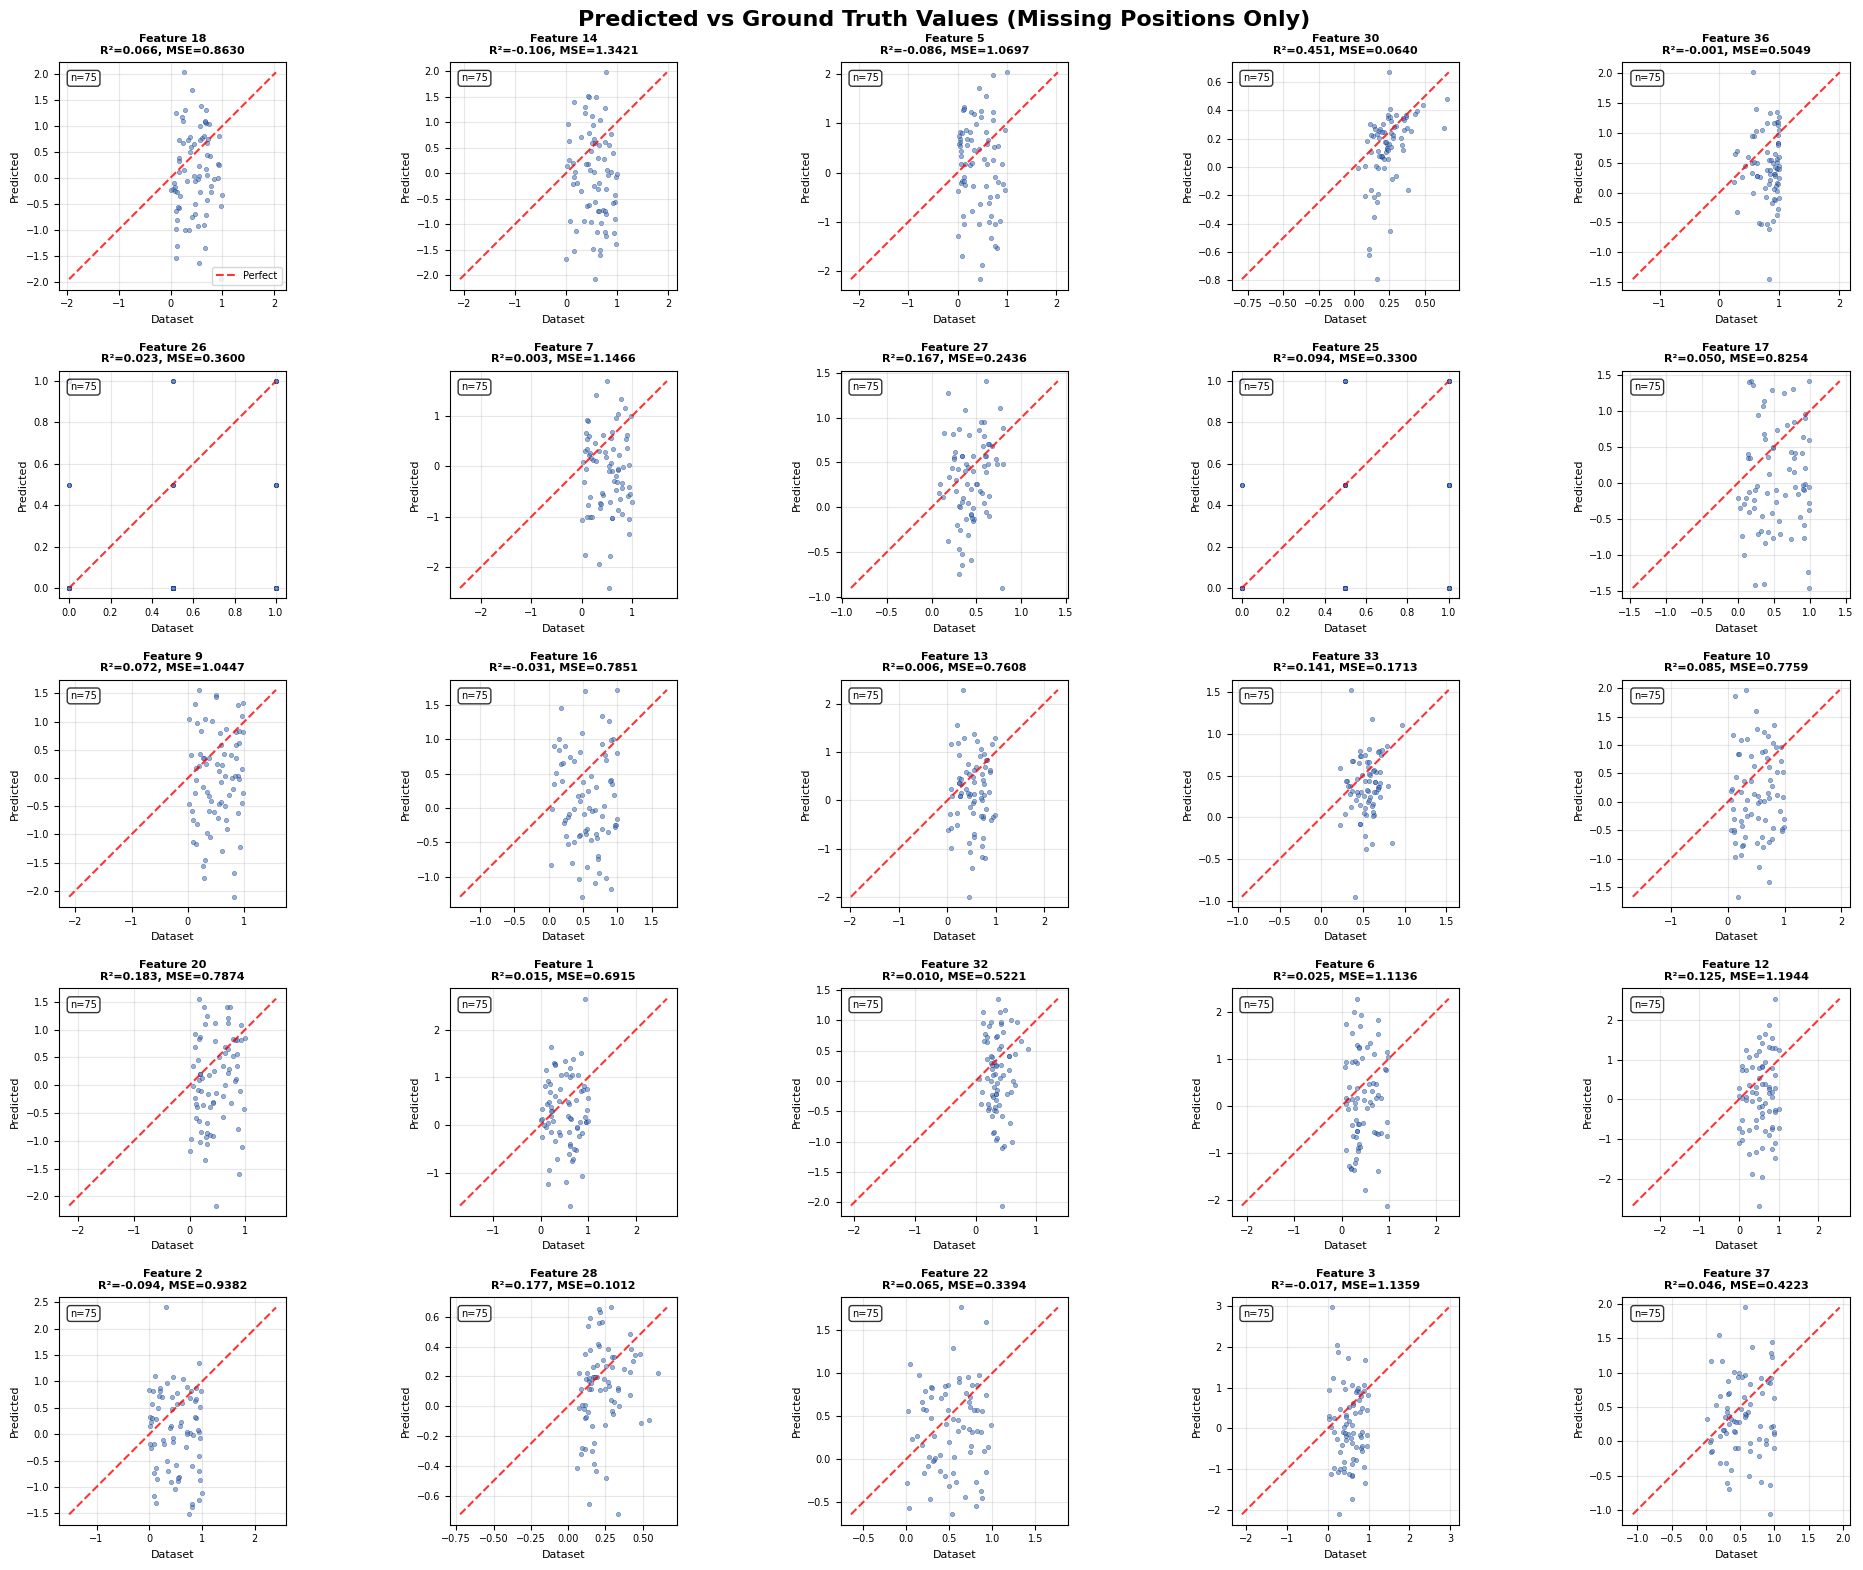

In [193]:
# Create the visualization
plot_prediction_scatter(test_imputations_denorm, test_original_denorm, test_masks, feature_names, n_features=37)



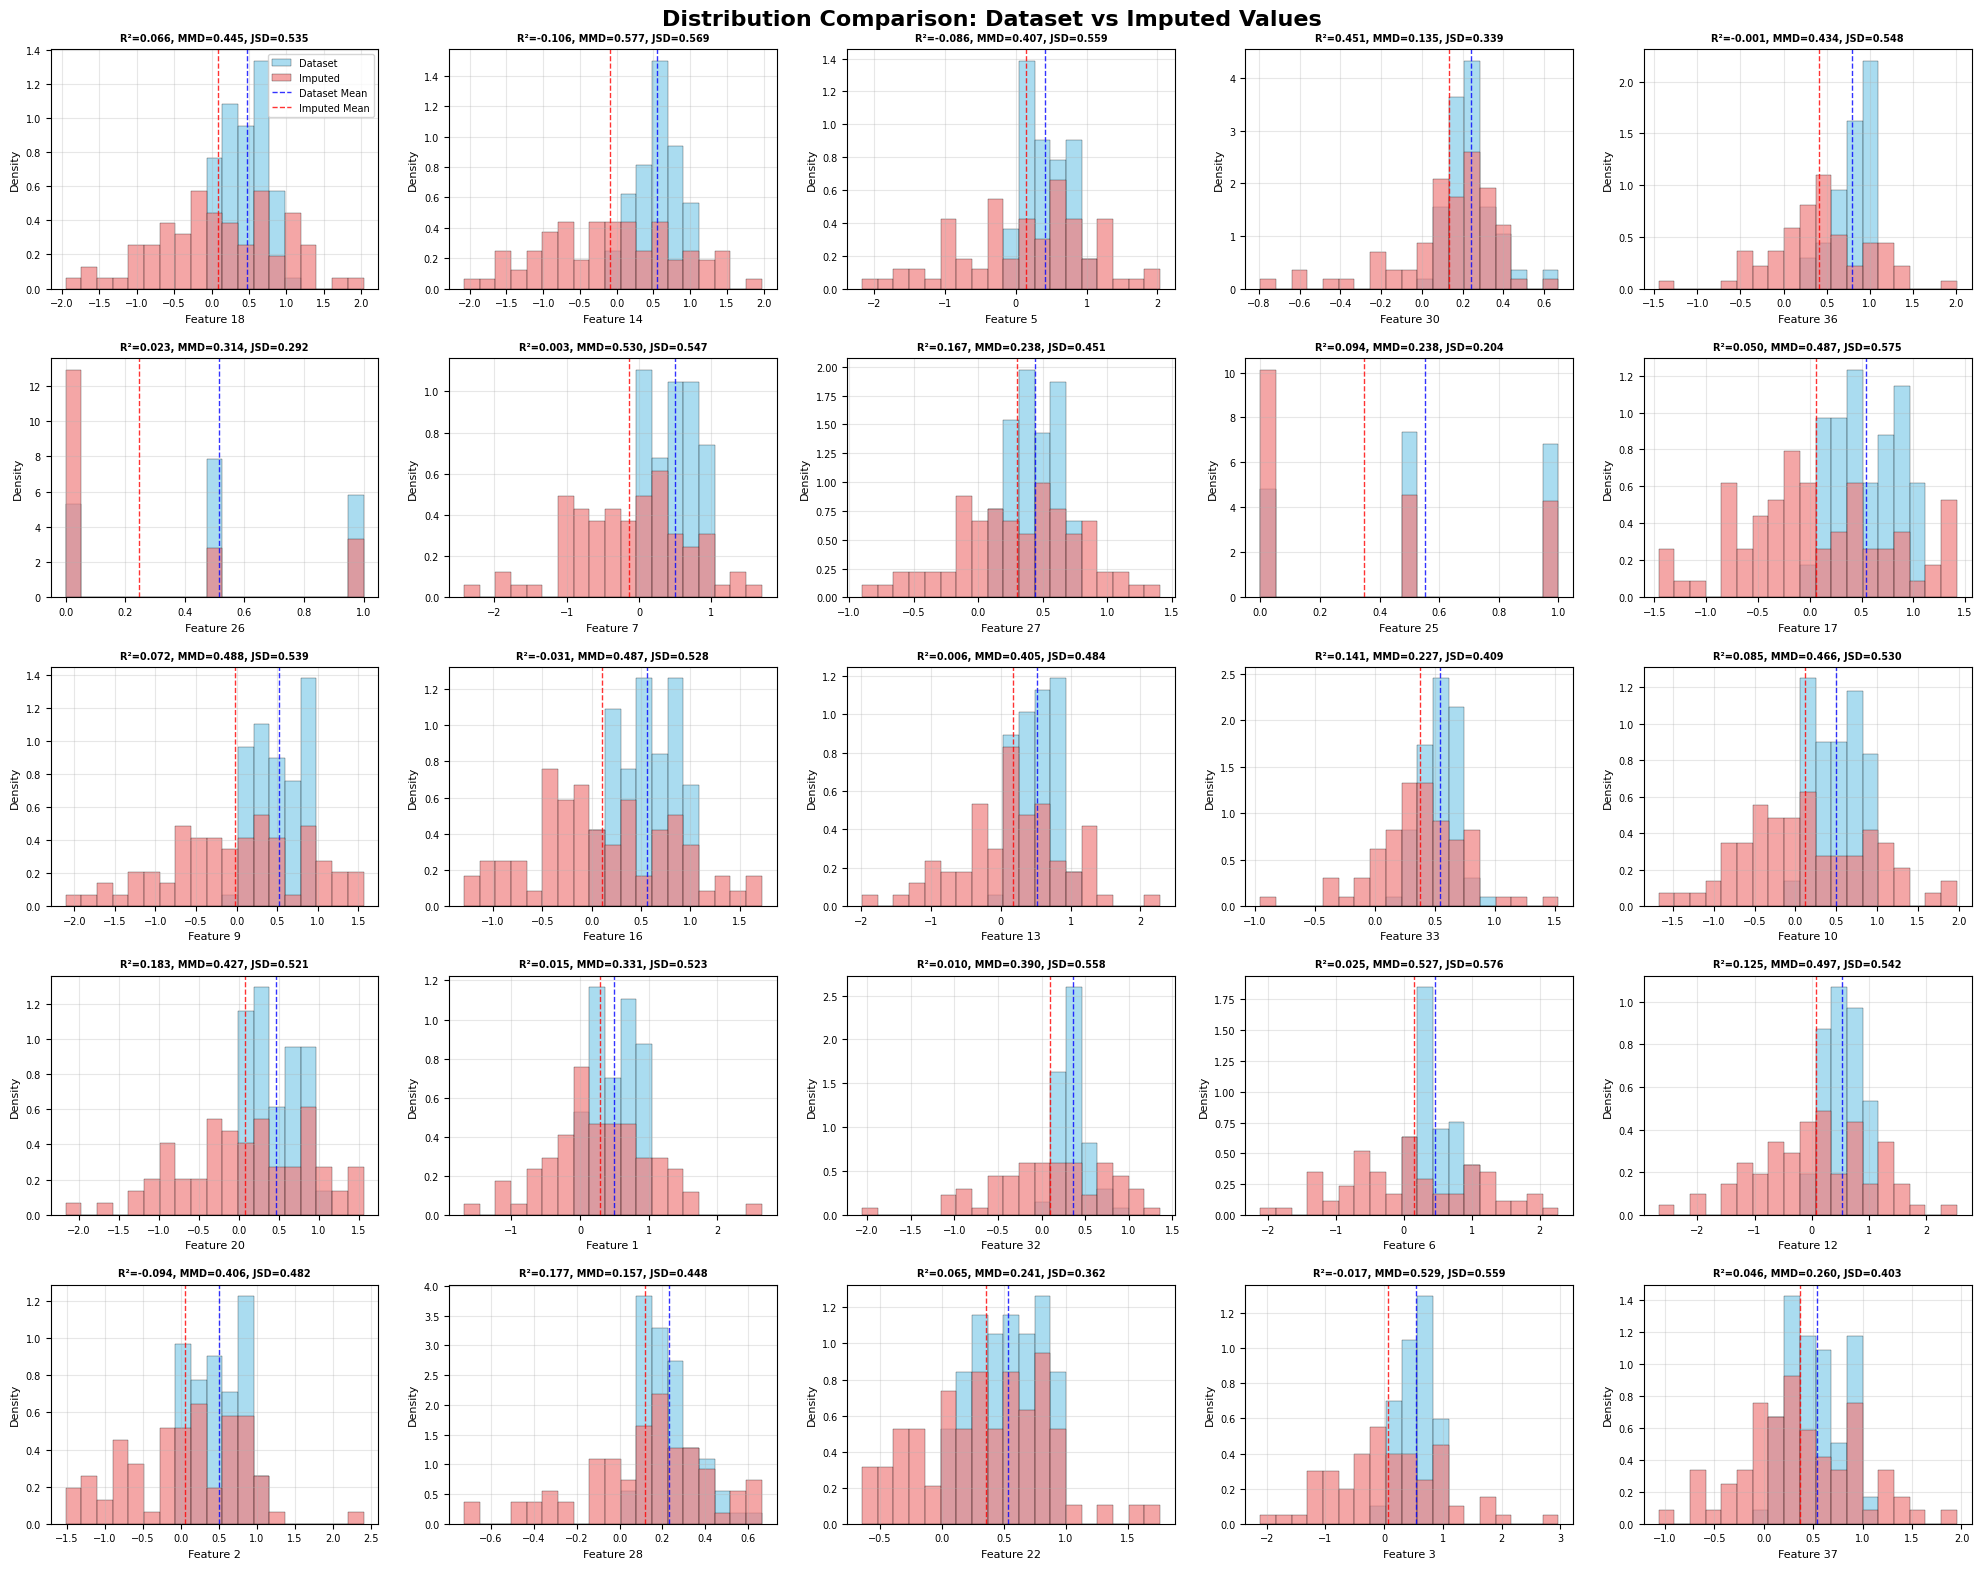

In [194]:
# Distribution comparison plots
plot_distribution_comparison(test_imputations_denorm, test_original_denorm,
                             test_masks, feature_names, n_features=25)


In [195]:
def generate_samples(model, X_test, test_loader, device, n_samples_per_test=100):
    """Generate multiple samples for a dataset using the trained model.
    """
    # We'll generate multiple samples
    test_samples = np.zeros((X_test.shape[0], n_samples_per_test, X_test.shape[1]))

    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        # Create a progress bar for all samples
        from tqdm import tqdm

        for batch_idx, (batch_data, batch_mask) in enumerate(tqdm(test_loader, desc="Generating Samples")):
            batch_data = batch_data.to(device)
            batch_mask = batch_mask.to(device)

            # Calculate the indices for this batch
            start_idx = batch_idx * test_loader.batch_size
            end_idx = min(start_idx + test_loader.batch_size, X_test.shape[0])
            actual_batch_size = end_idx - start_idx

            # Generate multiple samples for each item in the batch
            for j in range(n_samples_per_test):
                # Get imputed sample using the model's sampling method
                imputed = model.sample(batch_data, batch_mask)

                # Store the samples (already in original scale since we didn't normalize)
                test_samples[start_idx:end_idx, j, :] = imputed.cpu().numpy()
    print(f"✓ Generated samples shape: {test_samples.shape}")
    print(f"  - {test_samples.shape[0]} samples")
    print(f"  - {test_samples.shape[1]} generated variations per sample")
    print(f"  - {test_samples.shape[2]} features per sample")

    # Data is already in original scale (no denormalization needed)
    test_samples_final = test_samples.copy()

    # Calculate summary statistics
    mean_across_samples = test_samples_final.mean(axis=1)  # Mean across the 100 samples

    print(f"  - Range of means: [{mean_across_samples.min():.4f}, {mean_across_samples.max():.4f}]")

    return test_samples

In [196]:
# Test Evaluation

print("="*70)
print("TEST EVALUATION")
print("="*70)

# Generate multiple samples for test using the trained model
print(f"Generating 100 samples for each of {X_test.shape[0]} test samples...")

test_samples = generate_samples(
    model, X_test, test_loader, device, n_samples_per_test=100
)

TEST EVALUATION
Generating 100 samples for each of 375 test samples...


Generating Samples: 100%|██████████| 6/6 [00:14<00:00,  2.44s/it]

✓ Generated samples shape: (375, 100, 37)
  - 375 samples
  - 100 generated variations per sample
  - 37 features per sample
  - Range of means: [-0.2753, 1.0000]


In [197]:
from evaluate import *
test_score = compute_score(generated_samples=test_samples, set_name='test')
print("Test score:", test_score)

Loading data...
✓ Found data in current directory
✓ Test data shape: (375, 37)
✓ Missing ratio: 20.0%
✓ Generated samples shape: (375, 100, 37)

📊 EVALUATION RESULTS
Missing values evaluated: 2,775
MSE          : 0.1839
MAE          : 0.3431
Correlation  : 0.232
JS Divergence: 0.2147

📈 FEATURE-WISE RESULTS
Feature  MSE        MAE        Corr     JSDiv    Count   
0        0.1533     0.3240     0.514    0.3521   75      
1        0.2800     0.4435     0.245    0.3751   75      
2        0.2879     0.4690     0.186    0.5007   75      
3        0.2538     0.4271     -0.139   0.3921   75      
4        0.2112     0.3667     0.096    0.3115   75      
5        0.2136     0.3779     0.029    0.4704   75      
6        0.2340     0.4025     -0.026   0.3565   75      
7        0.2334     0.3991     0.002    0.4177   75      
8        0.2947     0.4592     0.037    0.4776   75      
9        0.2473     0.4134     0.100    0.4109   75      
10       0.2185     0.3841     0.086    0.3950   75  

In [78]:
# Test2 Evaluation

print("="*70)
print("TEST2 EVALUATION")
print("="*70)

# Generate multiple samples for test2 using the trained model
print(f"Generating 100 samples for each of {X_test2.shape[0]} test2 samples...")

test2_samples = generate_samples(
    model, X_test2, test2_loader, device, n_samples_per_test=100
)

TEST2 EVALUATION
Generating 100 samples for each of 417 test2 samples...


Generating Samples: 100%|██████████| 7/7 [00:14<00:00,  2.03s/it]

✓ Generated samples shape: (417, 100, 37)
  - 417 samples
  - 100 generated variations per sample
  - 37 features per sample
  - Range of means: [0.0000, 1.3648]


In [79]:
rng = np.random.default_rng()
id = rng.integers(1e8, 1e9-1)
np.save(f"{id}.npy", test2_samples)